## 4.1 NLP基础与语言模型

### 4.1.1 序列模型
很多数据都是具有时序信息的，比如说数字货币的收盘价格，如下图所示:
![image-20220316165404313](https://s2.loli.net/2022/03/16/IqeFs1KoO8pDhzm.png)

对序列数据来说：
* 数据值随时间变化而变化
* *音乐*、*语言*、*文本*、和*视频*都是连续的
* 预测明天的股价要比填补昨天遗失的股价更困难

**统计工具:**
在时间$t$观察到$x_t$， 那么得到$T$个不独立的随机变量$(x_1,...,x_T) \sim p(\mathbf{x})$

* 使用条件概率展开

$$
p(a, b)=p(a) p(b \mid a)=p(b) p(a \mid b)
$$

![image-20220204181132691](https://s2.loli.net/2022/02/04/ZuT7gXb85LvaHcN.png)

* 对条件概率建模
  * 也称为自回归模型

$$
p\left(x_{t} \mid x_{1}, \ldots x_{t-1}\right)=p\left(x_{t} \mid f\left(x_{1}, \ldots x_{t-1}\right)\right)
$$

**方案A - 马尔科夫假设**

* 假设当前当前数据只跟$\tau$个过去数据点相关

例如在过去数据上训练一个MLP
$$
p\left(x_{t} \mid x_{1}, \ldots x_{t-1}\right)=p\left(x_{t} \mid x_{t-\tau}, \ldots x_{t-1}\right)=p\left(x_{t} \mid f\left(x_{t-\tau,...,x_{t-1}}\right)\right.
$$

**方案B - 潜变量模型(latient variable)**

* 引入潜变量$h_t$来表示过去信息$h_t=f(x_1,...,x_{t-1})$
  * 这样$x_t=p(x_t|h_t)$

![image-20220204181853244](https://s2.loli.net/2022/02/04/BI7aeqKrugTLpn3.png)


下面我们来观看一些列子来直观理解使用MLP来模拟预测时间序列。

首先我们使用正弦函数和一些可加性的噪音来生成我们所需要的序列数据, 时间步长为1, 2,..., 1000。

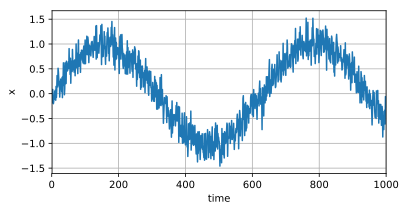

In [17]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

将数据映射为数据对$y_t=x_t$和$\mathbf{x_t} = [x_{t-\tau}, ..., x_{t-1}]$, 这里$\tau$大小为4:

In [18]:
tau = 4
features = torch.zeros((T - tau, tau))
features.shape

torch.Size([996, 4])

In [19]:
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

使用一个包含两个FCN的多层感知机

In [20]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

开始训练模型

In [21]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}',
              f'loss: {d2l.evaluate_loss(net, train_iter, loss)}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1 loss: 0.05103639199545509
epoch 2 loss: 0.051425414797114696
epoch 3 loss: 0.05173265718315777
epoch 4 loss: 0.050954775296543776
epoch 5 loss: 0.053721503550676925


预测下一个时间步：

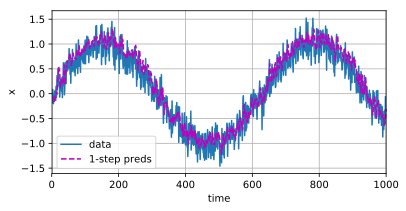

In [22]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3)
)

进行多步预测, 发现效果其实挺差的，因为每次误差都在累计：

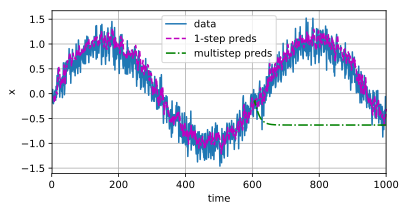

In [23]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

可以明显的看到，马尔科夫假设是无法预测较远的未来的！

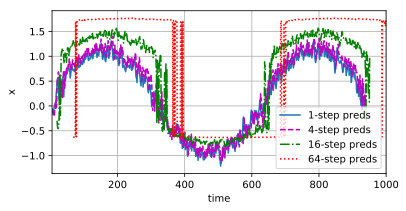

In [24]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))